In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from joblib import load

C:\anaconda3\envs\eui\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\anaconda3\envs\eui\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\anaconda3\envs\eui\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
imgFile = 'test_img.png'
img = cv2.imread(imgFile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h,w,_ = img.shape

if h > w and h/w > 2.2:
    img = cv2.resize(img, (w,h//2))
elif h < w and w/h > 2.2:
    img = cv2.resize(img, (w//2,h))

In [4]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
result_ss = ss.process()

img_dup = img.copy()

test_X = []
test_BB = []

for i in range(result_ss.shape[0]):
    if i > 2000:
        break
    
    x1,y1,w,h = result_ss[i]
    
    ts_img = img[y1:y1+h, x1:x1+w]
    ts_resize = cv2.resize(ts_img, (227,227), cv2.INTER_AREA)
    ts_resize = ts_resize.astype('float32')
    ts_resize = ts_resize/255
    test_X.append(ts_resize)
    test_BB.append([x1,y1,w,h])
    
test_X = np.array(test_X)
test_BB = np.array(test_BB)

In [5]:
json_file = open('alexnet_arch.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

loaded_model.load_weights("alexnet_weights.hdf5")

model = tf.keras.models.Model(loaded_model.input,loaded_model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       132748

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 5)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
test_feat = []
for i in tqdm.tqdm_notebook(range(test_X.shape[0])):
    test_feat.append(list(model.predict(np.expand_dims(test_X[i], axis=0))[0]))
test_feat = np.array(test_feat)

<ipython-input-6-4a682f74e61e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(test_X.shape[0])):


  0%|          | 0/1105 [00:00<?, ?it/s]

In [7]:
label = ['bicycle','bus','car','cat','cow','dog','horse','motorbike','person','sheep','background']
label_dict = dict()

for i,j in enumerate(label):
    label_dict[j] = i
label_dict

load_svm_model = load('Classify_object.pkl')

test_pred = load_svm_model.predict(test_feat)
test_pred_proba = load_svm_model.predict_proba(test_feat)

In [8]:
def pred_BB(P, dP):    
    G_x = P[2]*dP[0] + P[0]
    G_y = P[3]*dP[1] + P[1]
    G_w = P[2]*np.exp(dP[2])
    G_h = P[3]*np.exp(dP[3])
    
    return [G_x,G_y,G_w,G_h]

def get_label(pred_val):
    for k,v in label_dict.items():
        if v == pred_val:
            return k

In [10]:
load_reg_model = load('BB_regression.pkl')

pred_val = load_reg_model.predict(test_BB)

test_predBB = []
for i in range(test_BB.shape[0]):
    test_predBB.append(pred_BB(test_BB[i],pred_val[i]))

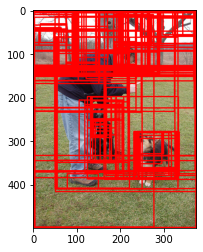

In [11]:
for i in range(test_X.shape[0]):
    if test_pred[i] != 10:
        x,y,w,h = test_predBB[i]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        imgBB = cv2.rectangle(img, (x,y),(x+w,y+h), (255, 0, 0), 2)

plt.imshow(imgBB)

In [13]:
def get_IOU(bb1,bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'],bb2['x1'])
    y_bottom = max(bb1['y1'],bb2['y1'])
    x_right = min(bb1['x2'],bb2['x2'])
    y_top = min(bb1['y2'],bb2['y2'])
    
    if (x_left > x_right) or (y_bottom > y_top):
        return 0.0
    
    area_intersect = (x_right - x_left) * (y_top - y_bottom)
    
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    total_area = bb1_area + bb2_area - area_intersect
    
    iou = area_intersect / total_area
    
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

def nnms(B, c, pred_label, overlap=0.5):
    D = []
    
    D_predlabel = []
    D_index =-1
      
    while len(B):
        max_c = 0
        for i in range(len(c)):
            if max_c < c[i]:
                max_c = c[i]
                max_index = i
                
        D.append(B[max_index])
        D_predlabel.append(pred_label[max_index])
        D_index += 1
        
        B = np.delete(B,max_index,axis=0)
        c = np.delete(c,max_index)
        pred_label = np.delete(pred_label,max_index)
        
        Dx1 = D[D_index][0]
        Dy1 = D[D_index][1]
        Dx2 = Dx1 + D[D_index][2]
        Dy2 = Dy1 + D[D_index][3]
        D_BB = {'x1': Dx1,'y1':Dy1,'x2':Dx2,'y2':Dy2}
        
        del_index = []
        for i in range(len(B)):
            Bx1 = B[i][0]
            By1 = B[i][1]
            Bx2 = Bx1 + B[i][2]
            By2 = By1 + B[i][3]
            
            B_BB = {'x1': Bx1,'y1':By1,'x2':Bx2,'y2':By2}
            
            if get_IOU(D_BB, B_BB) > overlap:
                del_index.append(i)

        B = np.delete(B,del_index,axis=0)
        c = np.delete(c,del_index)
        pred_label = np.delete(pred_label,del_index)
        
    return np.array(D), np.array(D_predlabel)

In [14]:
index_10 = []
for i in range(len(test_BB)):
    if test_pred[i] == 10:
        index_10.append(i)

In [15]:
ts_predBB = []
confidence_score = []
ts_predlabel = []

for i in range(len(test_pred)):
    if i not in index_10:
        ts_predBB.append(test_predBB[i])
        confidence_score.append(np.max(test_pred_proba[i]))
        ts_predlabel.append(test_pred[i])
        
ts_predBB = np.array(ts_predBB)
confidence_score = np.array(confidence_score)
ts_predlabel = np.array(ts_predlabel)

In [28]:
result, result_label = nnms(ts_predBB,confidence_score,ts_predlabel,0.00001)

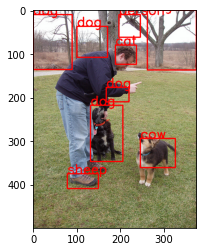

In [30]:
img = img_dup.copy()
for i in range(result.shape[0]):
    x,y,w,h = result[i]
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    imgBB = cv2.rectangle(img, (x,y),(x+w,y+h), (255, 0, 0), 2)
    cv2.putText(imgBB, get_label(result_label[i]),(x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

plt.imshow(imgBB)